In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib
import numpy as np

In [2]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
stop_words=set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rodrigo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/rodrigo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/rodrigo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize

In [4]:
df = pd.read_csv("imdb.csv", delimiter=";")
df = df.iloc[0:200]

In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's """"Love in the Time of Money"""" ...",positive


## Clean HTML tags

In [6]:
def clean_html_tags(html):
    soup = BeautifulSoup(html)
    return soup.get_text()
df['review'] = df['review'].apply(clean_html_tags)

In [7]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's """"Love in the Time of Money"""" ...",positive


## Clean punctuation

In [8]:
def clean_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    return " ".join(tokenizer.tokenize(text))
df['review'] = df['review'].apply(clean_punctuation)

In [9]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production The filming tech...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there s a family where a little boy ...,negative
4,Petter Mattei s Love in the Time of Money is a...,positive


## Remove Stop Words

In [10]:
def remove_stop_words(text):
    filtered_text = []
    for word in text.split():
        if not word in stop_words:
            filtered_text.append(word)
    return " ".join(filtered_text)
df['review'] = df['review'].apply(remove_stop_words)   

In [11]:
df.head()

,review,sentiment
0,One reviewers mentioned watching 1 Oz episode ...,positive
1,A wonderful little production The filming tech...,positive
2,I thought wonderful way spend time hot summer ...,positive
3,Basically family little boy Jake thinks zombie...,negative
4,Petter Mattei Love Time Money visually stunnin...,positive


## Apply Stemming

In [12]:
def apply_stemming(text):
    ps = PorterStemmer()
    return " ".join([ps.stem(x) for x in text.split()])
df['review'] = df['review'].apply(apply_stemming)    

In [13]:
df.head()

,review,sentiment
0,one review mention watch 1 Oz episod hook they...,positive
1,A wonder littl product the film techniqu unass...,positive
2,I thought wonder way spend time hot summer wee...,positive
3,basic famili littl boy jake think zombi closet...,negative
4,petter mattei love time money visual stun film...,positive


## Save to CSV

In [14]:
df.to_csv('imdb_clean.csv', encoding='utf-8', index=False)

## Start Trainig

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator

In [16]:
df = pd.read_csv("imdb_clean.csv")

In [17]:
df['sentiment'] = df['sentiment'].apply(lambda x: 0 if x == 'negative' else 1 )

In [18]:
df.head()

,review,sentiment
0,one review mention watch 1 Oz episod hook they...,1
1,A wonder littl product the film techniqu unass...,1
2,I thought wonder way spend time hot summer wee...,1
3,basic famili littl boy jake think zombi closet...,0
4,petter mattei love time money visual stun film...,1


In [19]:
count_vector = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = word_tokenize, max_features=200)
text_counts = count_vector.fit_transform(df['review'])

In [20]:
def choose_model(alg: str):
    model = None
    if alg == 'logistic_regression':
        model = GridSearchCV(
            LogisticRegression(n_jobs=-1),
            param_grid={
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'class_weight': [None, 'balanced']
            },
            scoring='f1',
            cv=StratifiedKFold(5),
            n_jobs=-1,
            verbose=1
        )
    elif alg == 'decision_tree':
        model = GridSearchCV(
            DecisionTreeClassifier(),
            param_grid={
                'criterion': ['gini', 'entropy'], 
                'splitter': ['best', 'random'],
                'min_samples_split': [4, 8, 16], 
                'min_samples_leaf': [1, 2, 4, 8],
                'max_depth': [None, 4, 8],
                'class_weight': [None, 'balanced']
            },
            scoring='f1',
            cv=StratifiedKFold(5),
            n_jobs=-1,
            verbose=1
        )
    elif alg == 'random_forest':
        model = GridSearchCV(
            RandomForestClassifier(n_estimators=50, n_jobs=-1),
            param_grid={
                'criterion': ['gini', 'entropy'],
                'min_samples_split': [16, 20, 24, 28, 32], 
                'max_depth': [None, 4, 8],
                'class_weight': [None, 'balanced']
            },
            scoring='f1',
            cv=StratifiedKFold(5),
            n_jobs=-1,
            verbose=1
        )
    elif alg == 'knn':
        model = GridSearchCV(
            KNeighborsClassifier(),
            param_grid={
                'n_neighbors': [3,5,7,9],
                'weights': ['uniform', 'distance']
            },
            scoring='f1',
            cv=StratifiedKFold(5),
            n_jobs=-1
        )
    elif alg == 'svm_linear':
        model = GridSearchCV(
            LinearSVC(),
            param_grid={
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'penalty': ['l1', 'l2'],
                'class_weight': [None, 'balanced']
            },
            scoring='f1',
            cv=StratifiedKFold(5),
            n_jobs=-1
        )
    elif alg == 'svm_kernel':
        model = GridSearchCV(
            SVC(),
            param_grid={
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'kernel': ['poly', 'rbf'],
                'degree': [2, 3, 4],
                'class_weight': [None, 'balanced']
            },
            scoring='f1',
            cv=StratifiedKFold(5),
            n_jobs=-1
        )
    elif alg == 'xgboost':
        model = GridSearchCV(
            XGBClassifier(n_estimators=50),
            param_grid={
                'max_depth': [None, 4, 8],
                'scale_pos_weight': [1, (549 / 342)] # neg / pos
            },
            scoring='f1',
            cv=StratifiedKFold(5),
            n_jobs=-1
        )

    return model


In [21]:
def return_features(train_index, test_index):
    X = text_counts
    y = df['sentiment'].values
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    return X_train, y_train, X_test, y_test

In [22]:
results = {}
for alg in ['logistic_regression', 'decision_tree', 'random_forest', 'knn' ]:
    folds = 10
    cv = StratifiedKFold(folds, shuffle=True, random_state=42)
    metrics_train = np.zeros(shape=(folds, 4))
    metrics_test = np.zeros(shape=(folds, 4))

    for fold, (train, test) in enumerate(cv.split(text_counts, df['sentiment'].values)):
        x_train, y_train, x_test, y_test = return_features(train, test)
        

        model = choose_model(alg)
        model.fit(x_train, y_train)

        y_pred_train = model.predict(x_train)
        accuracy = accuracy_score(y_train, y_pred_train)
        precision, recall, fscore, _ = precision_recall_fscore_support(y_train, y_pred_train, average='binary')
        metrics_train[fold, 0] = accuracy
        metrics_train[fold, 1] = precision
        metrics_train[fold, 2] = recall
        metrics_train[fold, 3] = fscore

        y_pred_test = model.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred_test)
        precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred_test, average='binary')
        metrics_test[fold, 0] = accuracy
        metrics_test[fold, 1] = precision
        metrics_test[fold, 2] = recall
        metrics_test[fold, 3] = fscore

    results[alg] = {
        'Train - Accuracy': metrics_train[:,0].mean(),
        'Train - Precision': metrics_train[:,1].mean(),
        'Train - Recall': metrics_train[:,2].mean(),
        'Train - Fscore': metrics_train[:,3].mean(),
        'Test - Accuracy': metrics_test[:,0].mean(),
        'Test - Precision': metrics_test[:,1].mean(),
        'Test - Recall': metrics_test[:,2].mean(),
        'Test - Fscore': metrics_test[:,3].mean(),

    }

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:    1.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.4s finished


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1425 out of 1440 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done 1425 out of 1440 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done 1425 out of 1440 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done 1425 out of 1440 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done 1425 out of 1440 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done 1425 out of 1440 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:    6.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:    7.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:    7.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:    7.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:    7.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:    7.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.4s finished


## Model metrics

In [24]:
def best_algorithm(results, metric_to_observe):
    best_algotithm = ""
    best_value = 0
    
    for algorithm_name, algorithm_metrics in results.items():
        for metric_name, metric_value in algorithm_metrics.items():
            if metric_name == metric_to_observe:
                if metric_value > best_value:
                    best_value = metric_value
                    best_algotithm = algorithm_name
    return (best_algotithm, metric_to_observe, best_value)

best_acurracy_results = best_algorithm(results, "Test - Accuracy")

best_algotithm, metric_to_observe, best_value = best_acurracy_results
print(best_algotithm)
print("{} = {}".format(metric_to_observe, best_value))

logistic_regression
Test - Accuracy = 0.75


## Model prediction

In [25]:
cv = StratifiedKFold(10, shuffle=True, random_state=42)
ground_truth = list()
predicted = list()

for fold, (train, test) in enumerate(cv.split(text_counts, df['sentiment'].values)):
    x_train, y_train, x_test, y_test = return_features(train, test)

    best_algotithm, _, _ = best_acurracy_results
    model = choose_model(best_algotithm)
    model.fit(x_train, y_train)
    y_predict = model.predict(x_test)

    ground_truth.extend(y_test)
    predicted.extend(y_predict)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print(classification_report(ground_truth, predicted))

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished


              precision    recall  f1-score   support

           0       0.79      0.77      0.78       115
           1       0.70      0.73      0.71        85

    accuracy                           0.75       200
   macro avg       0.74      0.75      0.75       200
weighted avg       0.75      0.75      0.75       200



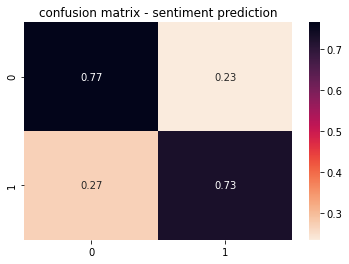

In [26]:
cm = confusion_matrix(ground_truth, predicted)
cm = np.transpose(cm.T / cm.astype(np.float).sum(axis=1))

plt.title("confusion matrix - sentiment prediction")
sns.heatmap(cm, annot=True, fmt='.2f', cmap='rocket_r')
plt.show()

In [27]:
model.best_params_

{'C': 0.1, 'class_weight': None}

## Production Model

In [28]:
x_complete = x_train
y_complete = y_train

In [29]:
def get_production_algorithm(algorithm, parameters):
    if algorithm == 'logistic_regression':
            return LogisticRegression(**parameters)
    elif algorithm == 'decision_tree':
            return DecisionTreeClassifier(**parameters)
    elif algorithm == 'random_forest':
            return RandomForestClassifier(**parameters),
    elif algorithm == 'knn':
            return KNeighborsClassifier(**parameters)
    elif algorithm == 'svm_linear':       
            return LinearSVC(**parameters),     
    elif algorithm == 'svm_kernel':
            return SVC(**parameters),
    elif algorithm == 'xgboost':
            return XGBClassifier(**parameters)

best_algorithm, _, _ = best_acurracy_results
production_model = get_production_algorithm(best_algorithm, model.best_params_)
production_model.fit(x_complete, y_complete)

LogisticRegression(C=0.1)

In [30]:
def compile_text(text):
    return [apply_stemming(remove_stop_words(clean_punctuation(clean_html_tags(text))))]

def predict_text(text):
    return ['negative', 'positive'][production_model.predict(count_vector.transform(compile_text(text)))[0]]

predict_text("I Hate This Movie this shit is dull")

'negative'

## Compare with nltk Sentiment analyzer

In [31]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [32]:
def predict_text_nltk(text):
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(text)
    if (scores['neg'] > scores['pos']):
        return 'negative'
    return 'positive'

In [33]:
sentences = [
        ("VADER is smart, handsome, and funny.", 'positive'), # positive sentence example
        ("VADER is smart, handsome, and funny and a good guy!", 'positive'), # punctuation emphasis handled correctly (sentiment intensity adjusted)
        ("VADER is very smart and greate man.", 'positive'),  # booster words handled correctly (sentiment intensity adjusted)
        ("VADER is VERY SMART, handsome, and FUNNY.", 'positive'),  # emphasis for ALLCAPS handled
        ("VADER is VERY SMART, handsome, and FUNNY!!!", 'positive'),# combination of signals - VADER appropriately adjusts intensity
        ("VADER is VERY SMART, really handsome, and INCREDIBLY FUNNY!!!", 'positive'),# booster words & punctuation make this close to ceiling for score
        ("The book was good.", 'positive'),         # positive sentence
        ("The book was kind of good.", 'positive'), # qualified positive sentence is handled correctly (intensity adjusted)
        ("The characters are uncompelling and the dialog is not great.", 'negative'), # mixed negation sentence
        ("A really bad, horrible book.", 'negative'),       # negative sentence with booster words
        ("At least it isn't a horrible book.", 'negative'), # negated negative sentence with contraction
        ("Today sucks", 'negative'),     #  negative slang handled
        ("Today sucks very very sucks!", 'negative'),    #  negative slang with punctuation emphasis handled
        ("Today sucks, but maybe wikk suck even more!", 'negative'),    #  negative slang with capitalization emphasis
        ("Today kinda sucks! But I'll get by, lol", 'negative') # mixed sentiment example with slang and constrastive conjunction "but"
        ]

In [34]:
negative_truth=0
positive_truth=0

negative_mine=0
positive_mine=0

negative_nltk=0
positive_nltk=0

for text, sentiment in sentences:
    
    if sentiment == 'negative':
        negative_truth += 1
    else:
        positive_truth += 1
        
    if predict_text(text) == 'negative':
        negative_mine += 1
    else:
        positive_mine += 1
    
    if predict_text_nltk(text) == 'negative':
        negative_nltk += 1
    else:
        positive_nltk += 1

In [35]:
print ("negative_truth={}".format(negative_truth))
print ("negative_mine={}".format(negative_mine))
print ("negative_nltk={}".format(negative_nltk))
print()
print ("positive_truth={}".format(positive_truth))
print ("positive_mine={}".format(positive_mine))
print ("positive_nltk={}".format(positive_nltk))


negative_truth=7
negative_mine=13
negative_nltk=5

positive_truth=8
positive_mine=2
positive_nltk=10
